# Исследование клиентов банка

В нашем распоряжении &mdash; данные о клиентах банка, которые воспользовались услугой кредитования. 

Нужно выяснить, какие факторы влияют на возвращение кредита в срок, чтобы банк мог оценивать свои риски при выдаче кредитов.

## Задачи исследования

**При подготовке данных:**

- Найти пропуски в значениях и заполнить, если это возможно/необходимо
- Найти и устранить дубликаты
- Выделить категории данных, удобные для последующего анализа

**При анализе данных:**

- Ответить на вопросы исследования &mdash; как семейное положение, наличие детей, уровень дохода и цели кредита влияют на возврат кредита в срок
- Подтвердить либо опровергнуть рабочие гипотезы
- Предложить рекомендации для бизнеса

**В качестве рабочих гипотез выдвинем следующие:**

1. _Клиенты без детей и многодетные семьи_ &mdash; более надёжные плательщики. Первые &mdash; за счет отсутствия лишних расходов, вторые &mdash; благодаря поддержке от государства (например, материнскому капиталу).
2. _Люди, состоящие в гражданском или официальном браке_ &mdash; более надёжные плательщики благодаря ведению общего хозяйства и наличию поддержки от партнера, в то время как у одиноких людей выше риск неуплаты в срок.
3. _Люди со средним доходом_ будут аккуратнее возвращать кредит, чем люди с низким или высоким доходом.
4. _Если цели менее амбициозные либо краткосрочные,_ то клиенты чаще будут платить в срок.

## Содержание

1. [Открытие файла и просмотр данных](#data_import)
2. [Предобработка данных](#data_review)
    * [Обработка пропущенных значений](#gaps)
    * [Проверка типа данных](#data_type)
    * [Обработка дубликатов и артефактов](#duplicates)
    * [Лемматизация](#lemmas)
    * [Категоризация данных](#categories)
3. [Анализ данных](#analysis)
    * [Зависимость между наличием детей и возвратом кредита в срок](#children)
    * [Зависимость между семейным положением и возвратом кредита в срок](#family)
    * [Зависимость между уровнем дохода и возвратом кредита в срок](#income)
    * [Зависимость между целями кредита и его возвратом в срок](#purpose)
4. [Общий вывод](#summary)
4. [Рекомендации для бизнеса](#tips)

### Открытие файла и просмотр данных. <a id="data_import"></a>

Импортируем библиотеки и отключим scientific notation.

In [1]:
# импорт базовых библиотек
import pandas as pd
import numpy as np
from IPython.display import display

# библиотеки для лемматизации и работы со списками
from pymystem3 import Mystem
from collections import Counter

# библиотеки для визуализации
from matplotlib import pyplot as plt

# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
# отключаем scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
%%javascript # отключаем автоскролл
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Откроем файл с данными от заказчика и посмотрим первые 10 строк.

In [4]:
data = pd.read_csv('/datasets/data.csv')
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639,покупка жилья
1,1,-4024.804,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014,приобретение автомобиля
2,0,-5623.423,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952,покупка жилья
3,3,-4124.747,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550,дополнительное образование
4,0,340266.072,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.078,сыграть свадьбу
5,0,-926.186,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565,покупка жилья
6,0,-2879.202,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.972,операции с жильем
7,0,-152.780,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934,образование
8,2,-6929.865,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832,на проведение свадьбы
9,0,-2188.756,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938,покупка жилья для семьи


Также ознакомимся с общей информацией о таблице &mdash; в частности, посмотрим на диапазоны значений.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [6]:
# описание численных значений
data.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000,19351.000,21525.000,21525.000,21525.000,21525.000,19351.000
mean,0.539,63046.498,43.293,0.817,0.973,0.081,167422.302
std,1.382,140827.312,12.575,0.548,1.420,0.273,102971.566
min,-1.000,-18388.950,0.000,0.000,0.000,0.000,20667.264
25%,0.000,-2747.424,33.000,1.000,0.000,0.000,103053.153
50%,0.000,-1203.370,42.000,1.000,0.000,0.000,145017.938
75%,1.000,-291.096,53.000,1.000,1.000,0.000,203435.068
max,20.000,401755.400,75.000,4.000,4.000,1.000,2265604.029


In [7]:
# описание категориальных значений
data.describe(include=['O'])

,education,family_status,gender,income_type,purpose
count,21525,21525,21525,21525,21525
unique,15,5,3,8,38
top,среднее,женат / замужем,F,сотрудник,свадьба
freq,13750,12380,14236,11119,797


### Вывод

В таблице более 20 тысяч строк и 12 столбцов. Каждая строка содержит информацию о клиенте банка: его возраст, трудовой стаж, семейное положение, количество детей, цели взятия кредита и так далее.

Замечены следующие проблемы:

- Непрозрачные названия столбцов.
- Отрицательные значения в 2 столбцах:
     - количество детей
     - трудовой стаж
- Выражение стажа в днях вместо лет, что неудобно для анализа.
- Явные пропуски значений в столбцах *'days_employed', 'total_income'.* 
- Непоследовательное написание значений в столбце *'education'* (разный регистр).
- Смысловые дубликаты в столбце *'purpose'* (например, "образование" и "дополнительное образование" - это одна и та же цель).
- Избыточная точность в значениях дохода и стажа.
- В столбце gender &mdash; три категории.

## Предобработка данных <a id="data_review"></a>

### Переименование столбцов

Выборочно переименуем столбцы: сделаем их более корректными (*total_income* заменим на *monthly_income*) и единообразными.

Выполним замену и проверим результат.

In [8]:
data = data.rename(columns = {'children': 'children_num',
                   'days_employed': 'employment_in_years',
                    'dob_years': 'age',
                    'education': 'education_type',
                     'debt': 'credit_debt', 
                    'total_income': 'monthly_income', 
                    'purpose': 'credit_purpose'        
                             }) 

data.columns

Index(['children_num', 'employment_in_years', 'age', 'education_type',
       'education_id', 'family_status', 'family_status_id', 'gender',
       'income_type', 'credit_debt', 'monthly_income', 'credit_purpose'],
      dtype='object')

### Обработка пропусков <a id="gaps"></a>

Пропуски были выявлены в двух столбцах - с информацией о стаже и о доходе. Вспомним, что в столбце _employment_in_years_ также попадались отрицательные значения. 

Разберемся сначала с этим и посмотрим, сколько таких значений. Вызовем повторно метод `describe()`.

In [9]:
data.employment_in_years.describe()

count    19351.000
mean     63046.498
std     140827.312
min     -18388.950
25%      -2747.424
50%      -1203.370
75%       -291.096
max     401755.400
Name: employment_in_years, dtype: float64

Отрицательных значений - не менее 75% от общего количества! Похоже на системную ошибку ввода или выгрузки данных, поэтому допустим, что сами значения стажа верны и просто уберем минус.

Затем проверим, что получилось.

In [10]:
data['employment_in_years'] = data['employment_in_years'].abs()

print('Количество отрицательных значений стажа:', 
      data[data['employment_in_years'] < 0]['employment_in_years']
      .count())

Количество отрицательных значений стажа: 0


Обратимся к пропускам в стаже. Предположим, что пропуски должны встречаться преимущественно у молодых клиентов, которые могли не накопить достаточно стажа. 

Чтобы проверить, сохраним строки без указания стажа в переменную `empty_employment`, сгруппируем данные по возрасту клиента и посчитаем, сколько клиентов какого возраста не указали свой стаж. Для удобства выведем данные на графике.

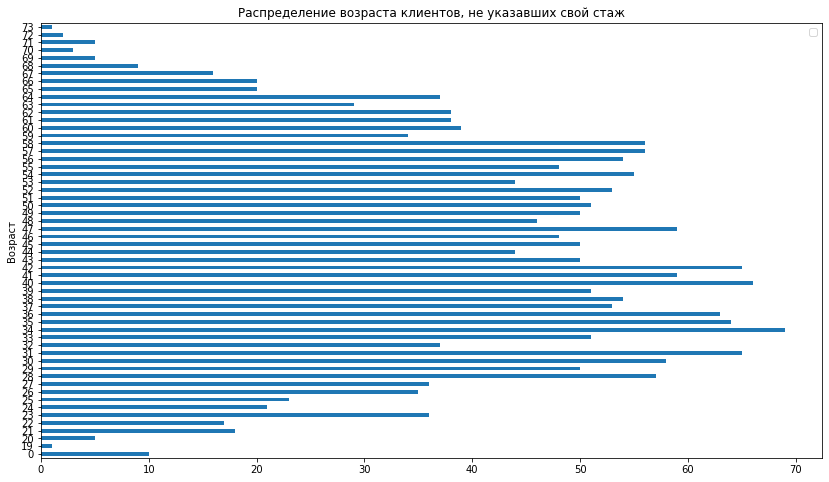

In [11]:
# сохраняем строки без стажа в переменную
empty_employment = data[data['employment_in_years'].isnull()]

# группируем данные и отрисовываем диаграмму
(empty_employment
     .groupby('age')
     .agg({'age': 'count'})
     .plot(kind='barh', 
           figsize=(14,8))
)

plt.title('Распределение возраста клиентов, не указавших свой стаж')
plt.ylabel('Возраст')
plt.legend('')
plt.show()

Гипотеза не подтвердилась - пропуски стажа распределились достаточно равномерно по клиентам от 19 до 73 лет, привязки к определенному возрасту нет. 

Заодно выявилась еще одна аномалия - 10 строк с нулевым значением возраста. Эти пропуски полностью случайны - возраст клиента банка должен быть старше 18, поэтому заполним пропуски характерными значениями. 

Найдем средний возраст заёмщиков.

In [12]:
avg_age = int(data[data['age'] !=0]['age'].mean())
print('Средний возраст:', avg_age)

Средний возраст: 43


Заменим нулевые значения возраста на среднее значение - 43 года. Затем выполним проверку.

In [13]:
data.loc[data['age'] ==0, 'age'] = avg_age
print('Клиентов с нулевым возрастом:', data[data['age'] == 0]['age'].count())

Клиентов с нулевым возрастом: 0


Теперь вернемся к пропускам стажа. Закономерности в пропусках не выявлено, поэтому допустимо заполнить их с использованием средних значений.

In [14]:
avg_employment = data[data['employment_in_years'] !=0]['employment_in_years'].mean()
print('Среднее значение стажа (в днях):', avg_employment)

Среднее значение стажа (в днях): 66914.72890682236


Для удобства переведем значение стажа из дней в годы.

In [15]:
avg_employment_years = avg_employment / 365
print('Средний стаж в годах:', avg_employment_years)

Средний стаж в годах: 183.32802440225305


Получили 183 года - явно неправдоподобно. Возможно, в данные закралось несколько аномально высоких значений, которые портят общую картину. Переведем все значения стажа в года.

In [16]:
data['employment_in_years'] = data.loc[:, 'employment_in_years'] / 365
data.head()

,children_num,employment_in_years,age,education_type,education_id,family_status,family_status_id,gender,income_type,credit_debt,monthly_income,credit_purpose
0,1,23.117,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639,покупка жилья
1,1,11.027,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014,приобретение автомобиля
2,0,15.407,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952,покупка жилья
3,3,11.301,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550,дополнительное образование
4,0,932.236,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.078,сыграть свадьбу


Так и есть, уже в первых строках таблицы попался стаж в 932 года. Оценим, много ли таких аномалий. Для этого распределим клиентов по 3 группам:

- 0-42 года стажа - "нормативный" стаж (за максимум взяли 42 года - такой стаж получится, если работать с 18 лет до наступления пенсионного возраста в 60 лет)
- 43-60 лет стажа - "высокий"
- более 61 лет стажа - "аномальный"

Объявим функцию для распределения клиентов в зависимости от стажа и протестируем на значениях 11, 42 и 932.

In [17]:
def employment_cat(years):
    """Распределяет стаж по трем категориям и возвращает название категории"""
    if years <= 42:
        return 'нормативный'
    elif 42 < years <= 60:
        return 'высокий'
    else:
        return 'аномальный'

print(employment_cat(11))
print(employment_cat(44))
print(employment_cat(932))

нормативный
высокий
аномальный


Теперь создадим новый столбец *employment_cat*, куда запишем категорию стажа. Выведем начало таблицы, чтобы посмотреть на результат.

In [18]:
data['employment_cat'] = data['employment_in_years'].apply(employment_cat)
data.head()

,children_num,employment_in_years,age,education_type,education_id,family_status,family_status_id,gender,income_type,credit_debt,monthly_income,credit_purpose,employment_cat
0,1,23.117,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639,покупка жилья,нормативный
1,1,11.027,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014,приобретение автомобиля,нормативный
2,0,15.407,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952,покупка жилья,нормативный
3,3,11.301,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550,дополнительное образование,нормативный
4,0,932.236,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.078,сыграть свадьбу,аномальный


In [19]:
#Подсчитаем, сколько клиентов в какой категории в зависимости от стажа
print(data['employment_cat'].value_counts())

нормативный    15896
аномальный      5619
высокий           10
Name: employment_cat, dtype: int64


Клиентов с аномально высоким стажем &mdash; больше четверти! Налицо какая-то ошибка ввода либо выгрузки данных &mdash; нужно сообщить об этом заказчику.

Сейчас не рассматриваем стаж как фактор, влияющий на платежеспособность клиентов, поэтому удалять или модифицировать эти строки не будем. 

Пропуски в стаже заполним исходя из медианного стажа для каждой категории занятости: госслужащих, студентов, пенсионеров и так далее. 

In [20]:
for income in data['income_type'].unique():
    median = data.loc[data['income_type'] == income, 'employment_in_years'].median()
    print(income, median)
    data.loc[(data['employment_in_years'].isna()) & (data['income_type'] == income), 'employment_in_years'] = median

сотрудник 4.312884441389274
пенсионер 1000.5844007280306
компаньон 4.239403349802557
госслужащий 7.3681324748065435
безработный 1003.8730212169988
предприниматель 1.4269810506722644
студент 1.5856206946252551
в декрете 9.032219074033039


Проверим, остались ли нулевые значения в столбце _employment_in_years_.

In [21]:
print('Пропусков в стаже:', data['employment_in_years'].isna().sum())

Пропусков в стаже: 0


Со стажем разобрались, теперь перейдем к пропускам в столбце с доходом. Оценим их общее количество.

In [22]:
print('Пропусков в сведениях о доходе:', data['monthly_income'].isna().sum())

Пропусков в сведениях о доходе: 2174


Пропусков около 1% от общего количества &mdash; возможно, это случайные пропуски или же клиенты умышленно не захотели раскрывать свой доход, но сказать наверняка нельзя. 

Поэтому игнорировать их мы не станем, а заполним, используя медиану. Чтобы учесть разницу в социальном положении, рассчитаем медианный доход также по типу занятости. 

In [23]:
for income in data['income_type'].unique():
    median_i = data.loc[data['income_type'] == income, 'monthly_income'].median()
    print(income, median_i)
    data.loc[(data['monthly_income'].isna()) & (data['income_type'] == income), 'monthly_income'] = median_i

сотрудник 142594.39684740017
пенсионер 118514.48641164352
компаньон 172357.95096577113
госслужащий 150447.9352830068
безработный 131339.7516762103
предприниматель 499163.1449470857
студент 98201.62531401133
в декрете 53829.13072905995


Проверим текущее состояние столбца.

In [24]:
print('Пропусков в сведениях о доходе:', data['monthly_income'].isna().sum())

Пропусков в сведениях о доходе: 0


Еще раз посмотрим общие сведения о нашей таблице и убедимся, что пропусков больше нет.

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
children_num           21525 non-null int64
employment_in_years    21525 non-null float64
age                    21525 non-null int64
education_type         21525 non-null object
education_id           21525 non-null int64
family_status          21525 non-null object
family_status_id       21525 non-null int64
gender                 21525 non-null object
income_type            21525 non-null object
credit_debt            21525 non-null int64
monthly_income         21525 non-null float64
credit_purpose         21525 non-null object
employment_cat         21525 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 2.1+ MB


### Вывод

Мы обнаружили пропуски в столбцах со значениями стажа и ежемесячного дохода. Попутно обнаружились некорректные (нулевые) значения в столбце с возрастом, отрицательные значения и аномально высокие значения стажа (более 60 лет).

- Отрицательные значения стажа заменены на положительные
- Пропуски в стаже и доходе заполнены при помощи медианных значений с группировкой по категории занятости: студент, госслужащий и так далее
- Нулевые значения возраста заполнены средним значением возраста (43 года)

Аномалии в значениях стажа - повод разобраться с выгрузкой либо заполнением исходных данных, однако для нашего исследования этот фактор не релевантен.

### Проверка типа данных <a id="data_type"></a>

Еще раз посмотрим сведения о таблице. 

In [26]:
data.dtypes

children_num             int64
employment_in_years    float64
age                      int64
education_type          object
education_id             int64
family_status           object
family_status_id         int64
gender                  object
income_type             object
credit_debt              int64
monthly_income         float64
credit_purpose          object
employment_cat          object
dtype: object

Похоже, что данные у нас нужного типа и менять ничего не нужно &mdash; количество детей в целых числах, стаж и доход &mdash; в дробях, категориальные переменные &mdash; object. Идем дальше.

### Вывод

Данные в таблице нужного типа &mdash; менять ничего не нужно.

### Обработка дубликатов и артефактов<a id="duplicates"></a>

Сначала поищем, нет ли в таблице строк со всеми совпадающими данными, то есть полных дубликатов.

In [27]:
data.duplicated().sum()

54

Таких строк 54. Вероятно, клиенты или сотрудники банка дважды нажали кнопку "Отправить", отсюда и дубликаты.

Удалим их полностью и обновим индекс.

In [28]:
data = data.drop_duplicates().reset_index(drop=True)
#повторно проверим количество дубликатов
data.duplicated().sum()

0

Теперь проверим значения в столбцах. Ранее мы заметили, что в столбце *education_type* есть дубликаты из-за использования разного регистра. Вероятно, проблема вызвана ручным вводом данных. 

Выведем список всех уникальных значений и приведем их к единому виду.

In [29]:
data['education_type'].value_counts()

среднее                13705
высшее                  4710
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   273
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education_type, dtype: int64

In [30]:
#для всех значений в столбце 'education_type' меняем регистр на нижний
data['education_type'] = data['education_type'].str.lower()
data['education_type'].value_counts()

среднее                15188
высшее                  5251
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education_type, dtype: int64

Данных по ученой степени слишком мало. Можем присоединить их к категории "высшее".

In [31]:
data['education_type'] = data.loc[:, 'education_type'].replace('ученая степень', 'высшее')
data['education_type'].value_counts()

среднее                15188
высшее                  5257
неоконченное высшее      744
начальное                282
Name: education_type, dtype: int64

В нашем исследовании фактор образования не учитывается, но зато данные теперь в порядке, если понадобится вернуться к ним в будущем. Перейдем к столбцу с семейным положением.

In [32]:
data['family_status'].value_counts()

женат / замужем          12344
гражданский брак          4163
Не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

Все категории в столбце *family_status* уникальны, так что просто приведем их к нижнему регистру.

In [33]:
data['family_status'] = data['family_status'].str.lower()

На всякий случай проверим столбец *children_num*.

In [34]:
data['children_num'].value_counts()

 0     14107
 1      4809
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children_num, dtype: int64

Вот те самые отрицательные значения. Предположим ошибку ввода и применим метод `abs()`, чтобы заменить все отрицательные значения на положительные.

In [35]:
data['children_num'] = data['children_num'].abs()

Также посмотрим на распределение значений.

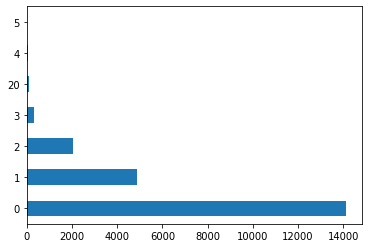

In [36]:
data['children_num'].value_counts().plot(kind='barh')
plt.show()

Настораживает выброс значений, равных 20, при полном отсутствии значений в промежутке между 6 и 20 &mdash; это противоречит нормальному распределению. 

Если это ошибка ввода (что наиболее вероятно), то лишняя цифра &mdash; 0 и количество детей равно 2. Выполним эту замену и убедимся, что теперь все в порядке.

In [37]:
data['children_num'] = data.loc[:, 'children_num'].replace(20, 2)
data['children_num'].value_counts()

0    14107
1     4856
2     2128
3      330
4       41
5        9
Name: children_num, dtype: int64

Проверим столбец *income_type* на предмет наличия дубликатов.

In [38]:
data['income_type'].value_counts()

сотрудник          11091
компаньон           5080
пенсионер           3837
госслужащий         1457
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

Здесь также все в порядке. Остался столбец с целями кредита. Посмотрим на их перечень, чтобы убедиться, что в нем нет дубликатов по регистру.
<a id="purpose_list"></a>

In [39]:
data['credit_purpose'].value_counts()

свадьба                                   793
на проведение свадьбы                     773
сыграть свадьбу                           769
операции с недвижимостью                  675
покупка коммерческой недвижимости         662
покупка жилья для сдачи                   652
операции с жильем                         652
операции с коммерческой недвижимостью     650
покупка жилья                             646
жилье                                     646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          625
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

С регистром все в порядке, но в формулировках много повторов (*покупка жилья, покупка жилой недвижимости и покупка жилья для семьи* &mdash; одна и та же цель). Причина, скорее всего, заключается в свободном заполнении поля в анкете (вместо выбора одного из предложенных вариантов) &mdash; стоит обратить на это внимание сотрудников банка.

Чтобы привести данные в пригодный для анализа вид, далее используем лемматизацию.

Последний пункт &mdash; столбец gender, в котором обнаружены 3 категории. Выведем все уникальные значения.

In [40]:
data['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

Значение XNA говорит о том, что скорее всего эту графу не заполняли (нет данных). Допустимый вариант, оставим как есть. 

### Вывод

В результате предобработки данных:

- Найдены и удалены полные дубликаты (54 строки)
- Устранены дубликаты в столбце с уровнем образования (дубликаты за счет использования разного регистра)
- Найдены смысловые дубликаты в столбце с целями кредита
- Исправлены некорректные значения (артефакты) в столбце с количеством детей

Возможные причины появления дубликатов:

- Ручной ввод данных (ошибка ввода)
- Повторная отправка заявок / сбой на сервере
- Формат заявки на получение кредита со свободным вводом вместо множественного выбора

### Лемматизация <a id="lemmas"></a>

В текущем виде анализировать цели кредита затруднительно. Цели похожи, но используются различные формулировки.

Создадим новый столбец *credit_purpose_lem* и запишем в него лемматизированные значения столбца *credit_purpose*. Посмотрим на начало таблицы.

In [41]:
m = Mystem()

def my_lemmatize(x):
    """Возвращает лемматизированные значения"""
    new = m.lemmatize(x)
    return new

data['credit_purpose_lem'] = data['credit_purpose'].apply(my_lemmatize)
   
data[['credit_purpose', 'credit_purpose_lem']].head()

,credit_purpose,credit_purpose_lem
0,покупка жилья,"[покупка, , жилье, \n]"
1,приобретение автомобиля,"[приобретение, , автомобиль, \n]"
2,покупка жилья,"[покупка, , жилье, \n]"
3,дополнительное образование,"[дополнительный, , образование, \n]"
4,сыграть свадьбу,"[сыграть, , свадьба, \n]"


Теперь нужно оценить, какие цели встречаются чаще всего. Объединим выделенные леммы в один список `lemmas_all` и выведем на экран первые 10 записей.

In [42]:
lemmas_all = []
for row in data['credit_purpose_lem']:
    x = "".join(row)
    lemmas_all.append(x)
 
print(lemmas_all[:10])

['покупка жилье\n', 'приобретение автомобиль\n', 'покупка жилье\n', 'дополнительный образование\n', 'сыграть свадьба\n', 'покупка жилье\n', 'операция с жилье\n', 'образование\n', 'на проведение свадьба\n', 'покупка жилье для семья\n']


Наш список состоит из строк, а мы будем подсчитывать отдельные леммы. Разобъем строки по пробелу и сохраним в список `lemmas_new`. Также посмотрим на первые 10 записей.

In [43]:
lemmas_new = []
for word in lemmas_all:
    x = word.split()
    lemmas_new += x
print(lemmas_new[:10])

['покупка', 'жилье', 'приобретение', 'автомобиль', 'покупка', 'жилье', 'дополнительный', 'образование', 'сыграть', 'свадьба']


Отдельные леммы - то, что нам нужно. Теперь подсчитаем количество упоминаний для каждой леммы.

In [44]:
# подсчитаем леммы и сохраним их в словарь
d = Counter(lemmas_new)

# преобразуем словарь в таблицу
df = pd.DataFrame.from_dict(d, orient='index').reset_index()

# переименуем столбцы и отсортируем по убыванию
df.columns = ['lemma', 'count']
df = df.sort_values(by = 'count', ascending=False)
df

,lemma,count
14,недвижимость,6353
0,покупка,5900
1,жилье,4461
3,автомобиль,4308
5,образование,4014
9,с,2918
8,операция,2604
7,свадьба,2335
20,свой,2231
10,на,2228


За вычетом служебных слов (предлогов и местоимений), в топ вошли слова: *недвижимость, покупка, жилье, автомобиль, образование, операция, свадьба, строительство*. 
Слова  *покупка, сделка, операции, коммерческий, жилой* носят описательный характер, поэтому отдельной категории они не составят. Остальные слова можно распределить по категориям:

- **недвижимость** - недвижимость, жилье, строительство
- **автомобиль** - автомобиль
- **образование** - образование
- **свадьба** - свадьба

В принципе, эти 4 категории можно было выделить и вручную, просматривая полученный ранее [список целей кредита](#purpose_list), но так мы убедились, что точно не пропустили какую-то важную категорию. 

### Вывод

В результате лемматизации столбца с целями кредита:

- Получен список с отдельными леммами (*'покупка', 'жилье', 'приобретение'* и т.п.)
- Выполнен подсчет лемм
- В результате частотного анализа выделены 4 основные категории, по которым можно распределить цели кредита

### Категоризация данных <a id="categories"></a>

Пока что данные у нас разрозненные. Начнем их группировать, чтобы выделить тенденции, общие для групп, и ответить на вопросы исследования.

В предыдущей части мы выделили 4 категории для целей кредита. Напишем функцию, которая распределит все цели по одной из этих категорий, и проверим на примерах.

In [45]:
def purpose_category(purpose_lem):
    """Распределяет цели кредита по 4 категориям"""
    if 'жилье' in purpose_lem or 'недвижимость' in purpose_lem:
        return 'недвижимость'
    elif 'свадьба' in purpose_lem:
        return 'свадьба'
    elif 'образование' in purpose_lem:
        return 'образование'
    elif 'автомобиль' in purpose_lem:
        return 'автомобиль'
    
print(purpose_category('[дополнительный, , образование, \n]'))
print(purpose_category('[покупка, , жилье, , для, , семья, \n]'))

образование
недвижимость


Теперь применим функцию к столбцу *credit_purpose_lem* и запишем результат в новый столбец *credit_purpose_cat*. 

In [46]:
data['credit_purpose_cat'] = (data['credit_purpose_lem']
                              .apply(purpose_category)
                             )

data[['credit_purpose', 'credit_purpose_cat', 'credit_purpose_lem']].head()

,credit_purpose,credit_purpose_cat,credit_purpose_lem
0,покупка жилья,недвижимость,"[покупка, , жилье, \n]"
1,приобретение автомобиля,автомобиль,"[приобретение, , автомобиль, \n]"
2,покупка жилья,недвижимость,"[покупка, , жилье, \n]"
3,дополнительное образование,образование,"[дополнительный, , образование, \n]"
4,сыграть свадьбу,свадьба,"[сыграть, , свадьба, \n]"


Убедимся, что каждая строка отнесена к той или иной категории целей. Для этого посчитаем количество пропусков в столбце с целями.

In [47]:
print('Пропусков в столбце с целями:', data['credit_purpose_cat'].isna().sum())

Пропусков в столбце с целями: 0


Теперь обратимся к столбцу с доходом. Сначала оценим данные в целом: найдем минимальное и максимальное значения и медиану.

In [48]:
print('Минимальный доход:', data['monthly_income'].min())
print ('Максимальный доход:', data['monthly_income'].max())
print ('Медианный доход:', data['monthly_income'].median())

Минимальный доход: 20667.26379327158
Максимальный доход: 2265604.028722744
Медианный доход: 142594.39684740017


Нам неизвестен контекст - ни регион, ни временной период, поэтому сделать привязку к прожиточному минимуму или показателям Росстата не получится. Условно можно выделить 4 категории:

- Низкий - до 100 тысяч
- Средний - от 100 до 150 тысяч
- Выше среднего - от 150 тысяч до 250 тысяч
- Высокий - более 250 тысяч

Напишем функцию для отнесения дохода к одной из категорий и проверим ее на примерах.

In [49]:
def income_category(x):
    """Относит доход к одной из 4 категорий"""
    if x < 100000:
        return 'низкий'
    elif 100000 <= x < 150000:
        return 'средний'
    elif 150000 <= x < 250000:
        return 'выше среднего'
    else:
        return 'высокий'

print(income_category(59000))
print(income_category(165300))
print(income_category(560000))

низкий
выше среднего
высокий


Применим функцию к столбцу *monthly_income* и сохраним результат в новый столбец *monthly_income_cat*.

In [50]:
data['monthly_income_cat'] = (data['monthly_income']
                              .apply(income_category)
                             )

data[['monthly_income', 'monthly_income_cat']] .head()

,monthly_income,monthly_income_cat
0,253875.639,высокий
1,112080.014,средний
2,145885.952,средний
3,267628.550,высокий
4,158616.078,выше среднего


In [51]:
data['monthly_income_cat'].value_counts()

средний          7175
выше среднего    7020
низкий           4463
высокий          2813
Name: monthly_income_cat, dtype: int64

Информация о наличии детей сейчас представлена в виде количественных данных - от 0 до 5. Согласно нашей гипотезе, многодетные семьи входят в "группу риска" с точки зрения платежеспособности. Поэтому удобнее разделить клиентов на 3 категории:

- бездетные 
- 1-2 детей
- многодетные (3 и более детей - именно так классифицируют многодетные семьи в России)

Объявим функцию `children_category` и проверим ее на примерах. Затем применим ее к столбцу *children_num* и сохраним данные в новый столбец.

In [52]:
def children_category(x):
    """Относит количество детей к одной из 3 категорий"""
    if x == 0:
        return 'бездетные'
    elif x == 1 or x == 2:
        return '1-2 детей'
    else:
        return 'многодетные'

print(children_category(2))
print(children_category(4))
print(children_category(0))

1-2 детей
многодетные
бездетные


In [53]:
data['children_num_cat'] = (data['children_num']
                            .apply(children_category)
                           )

data[['children_num', 'children_num_cat']].head()

,children_num,children_num_cat
0,1,1-2 детей
1,1,1-2 детей
2,0,бездетные
3,3,многодетные
4,0,бездетные


### Вывод

Мы сгруппировали данные о детях, доходе и целях кредита по категориям:

- Категории для целей кредита выделены на основе частотного анализа лемм
- Категории для уровня дохода не привязаны к социальному контексту и используются для описания данной отдельно взятой выборки
- Категории по количеству детей выделены так, чтобы можно было работать с нашей гипотезой о многодетных семьях 


## Анализ данных <a id="analysis"></a>

### Зависимость между наличием детей и возвратом кредита в срок <a id="children"></a>

Объявим функцию `pivot_data`, которая в качестве аргумента будет принимать столбец из таблицы `data` и возвращать сводную таблицу с данными по должникам. Значения из этого столбца станут индексом новой таблицы.

In [54]:
def pivot_data(factor):
    """
    Принимает в качестве аргумента столбец с категорией (factor) из основной таблицы.
    Строит сводную таблицу, где в строках - та или иная категория (количество детей, семейное положение, уровень дохода).
    Добавляет столбцы с долей клиентов-должников и не-должников.
    Выводит результирующую сводную таблицу.
    """
    table = data.pivot_table(index = factor, 
                                   columns = 'credit_debt', 
                                   values = 'monthly_income', 
                                   aggfunc = 'count')
    # переименуем столбцы
    table.columns = ['no_debt', 'debt']
    
    # вычислим долю должников и аккуратных плательщиков в %
    table['no_debt_part'] = (table['no_debt'] /
                                   (table['no_debt'] + table['debt'])
                                  )

    table['debt_part'] = (table['debt'] / 
                                (table['no_debt'] + table['debt'])
                               )
    return (table
         .sort_values(by='debt_part', ascending = False)
         .style.format({'no_debt_part':'{:.2%}', 
                        'debt_part':'{:.2%}'})
           )

Выведем таблицу, задав в качестве аргумента столбец с категорией количества детей.

In [55]:
pivot_data('children_num_cat')

,no_debt,debt,no_debt_part,debt_part
children_num_cat,,,,
1-2 детей,6337,647,90.74%,9.26%
многодетные,349,31,91.84%,8.16%
бездетные,13044,1063,92.46%,7.54%


На первый взгляд, рабочая гипотеза подтвердилась. Действительно, клиенты с 1-2 детьми несколько чаще оказываются в должниках, чем бездетные или многодетные клиенты.

Вопрос в том, можно ли назвать это различие значимым. Например, по многодетным выборка слишком мала, чтобы делать уверенные выводы.

### Зависимость между семейным положением и возвратом кредита в срок <a id="family"></a>

Воспользуемся функцией `pivot_data` и построим аналогичную таблицу с данными по семейному положению.

In [56]:
pivot_data('family_status')

,no_debt,debt,no_debt_part,debt_part
family_status,,,,
не женат / не замужем,2536,274,90.25%,9.75%
гражданский брак,3775,388,90.68%,9.32%
женат / замужем,11413,931,92.46%,7.54%
в разводе,1110,85,92.89%,7.11%
вдовец / вдова,896,63,93.43%,6.57%


Рабочая гипотеза подтвердилась лишь частично:

- Наибольший риск с точки зрения платежеспособности представляют одинокие люди, но только те, кто никогда не был в браке.
- При этом разведенные или вдовые люди, наоборот, скорее склонны вносить оплату в срок. 
- Примерно такой же уровень риска, как у неженатых/незамужних - у людей в гражданском браке. Вероятно, это связано с неустойчивостью гражданского брака как института в нашей стране.
- У женатых/замужних риск неуплаты меньше, но не минимален.


### Зависимость между уровнем дохода и возвратом кредита в срок <a id="income"></a>

Снова построим сводную таблицу, теперь в качестве аргумента укажем столбец с категорией дохода &mdash; `monthly_income_cat`.

In [57]:
pivot_data('monthly_income_cat')

,no_debt,debt,no_debt_part,debt_part
monthly_income_cat,,,,
средний,6551,624,91.30%,8.70%
выше среднего,6451,569,91.89%,8.11%
низкий,4109,354,92.07%,7.93%
высокий,2619,194,93.10%,6.90%


Рабочая гипотеза не подтверждена. Люди со средним доходом и выше среднего (от 100 до 250 тысяч) оказываются в должниках примерно так же часто, как и люди с низким доходом. Значит, какой-то закономерности здесь нет.

Исключение составляют люди с высоким доходом, они более надежные плательщики. По всей видимости, у них наиболее стабильные источники заработка.

### Зависимость между целями кредита и его возвратом в срок <a id="purpose"></a>

Наконец, изучим влияние целей кредита на его возврат в срок. Построим сводную таблицу на основе столбца `credit_purpose_cat`.

In [58]:
pivot_data('credit_purpose_cat')

,no_debt,debt,no_debt_part,debt_part
credit_purpose_cat,,,,
автомобиль,3905,403,90.65%,9.35%
образование,3644,370,90.78%,9.22%
свадьба,2149,186,92.03%,7.97%
недвижимость,10032,782,92.77%,7.23%


Рабочая гипотеза не подтверждена. Наблюдаются такие тенденции:

- Наиболее аккуратные выплаты - по долгосрочным кредитам, связанным с недвижимостью, и краткосрочным кредитам на свадьбы.
- Больше должников по кредитам, взятым на приобретение автомобиля либо получение образования.

Такой расклад можно объяснить тем, что автомобиль является импульсивной или "статусной" покупкой, чаще совершается в одиночку, в то время как приобретение недвижимости и празднование свадеб планируется заблаговременно и совместно с партнером. 

В случае с образованием также должно иметь место планирование, однако риски наравне с покупкой автомобиля. Возможно, дело также в том, что образование люди получают самостоятельно и не могут рассчитывать на то, что кто-то разделит их расходы.

### Общий вывод <a id="summary"></a>

В ходе исследования мы обнаружили зависимости между количеством детей, семейным положением, целями кредита и платежеспособностью клиентов.

Взаимосвязь между уровнем дохода и платежеспособностью почти не просматривается. Исключение - люди с высоким уровнем дохода: они более надежные плательщики.

По некоторым категориям клиентов (например, многодетным семьям) выборка мала, чтобы делать уверенные выводы.

Больше рисков с точки зрения выплаты кредита представляют:

- люди с 1-2 детьми (по сравнению с бездетными)
- неженатые/незамужние или люди, состоящие в гражданском браке
- люди, берущие кредит на автомобиль или получение образования 

### Рекомендации для бизнеса <a id="tips"></a>

- Проверить скрипты выгрузки данных, чтобы убедиться, что статистика собирается корректно 
- Доработать форму заявки, чтобы при введении ошибочных значений (например, нулевого возраста, отрицательного или аномально высокого стажа) появлялась подсказка
- Доработать форму заявки, чтобы вместо свободного ввода предлагались опции на выбор в полях цели кредита, образования и типа занятости 
- Обработать случаи повторной отправки заявок на кредит, чтобы предотвратить появление полных дубликатов